In [1]:
# Imports for core lib
import numpy as np
from typing import Dict, Hashable, Tuple
import itertools

import torch as th
from torchvision import transforms
from pytorch3d.ops.perspective_n_points import efficient_pnp
from pytorch3d.transforms import so3_relative_angle
from pytorch3d.transforms.rotation_conversions import quaternion_to_matrix, matrix_to_quaternion

In [2]:
# Imports for visualization
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Imports for Data
from top.data.objectron_detection import ObjectronDetection
from top.data.colored_cube_dataset import ColoredCubeDataset
from top.data.schema import Schema

In [4]:
dataset = ObjectronDetection(ObjectronDetection.Settings(), False)
idata = iter(dataset)

In [5]:
data_0 = next(idata)
data = data_0

/home/jamiecho/Repos/Ravel/ai604-video-object-pose/src/top/data/objectron_detection.py:52: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  image = thio.decode_image(th.from_numpy(image_bytes))


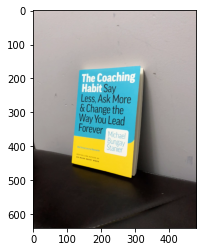

In [6]:
image = data[Schema.IMAGE].permute(1,2,0).detach().cpu().numpy()
plt.imshow(image)
plt.show()

In [55]:
def get_cube_points() -> th.Tensor:
    """ Get cube points, sorted in descending order by axes and coordinates. """
    points_3d = list(itertools.product(
        *zip([-0.5, -0.5, -0.5], [0.5, 0.5, 0.5])))
#     points_3d = np.insert(points_3d, 0, [0, 0, 0], axis=0)
    points_3d = th.as_tensor(points_3d, dtype=th.float32).reshape(-1, 3)
    return points_3d

def calc_location(box_2d, proj_matrix, dimension, quaternion, gt_trans):
    #global orientation
    R = (quaternion_to_matrix(th.as_tensor(quaternion))
         .detach().cpu().numpy())

    # format 2d corners
#     xmin, ymin, xmax, ymax = box_2d

    # left top right bottom
#     box_corners = [xmin, ymin, xmax, ymax]
    box_corners = box_2d
    
    T_box = np.zeros((4, 4), dtype=np.float32)
    T_box[..., :3, :3] = np.matmul(R, np.diag(dimension))
    T_box[..., :3, -1] = gt_trans
    T_box[..., 3, 3] = 1
    T_p = proj_matrix.reshape(4, 4)
    T = np.matmul(T_p, T_box)
    
    v3 = np.einsum('...ab, kb -> ...ka',
                      T[..., :3, :3], get_cube_points()) + T[..., None, :3, -1]
    v2 = v3[...,:2] / v3[...,2:]
    
    imin = np.argmin(v2, 0)
    imax = np.argmax(v2, 0)
    indices = [imin[0], imin[1], imax[0], imax[1]]
    vertices = get_cube_points() * dimension
    constraints = [vertices[indices]]
#     constraints = list(itertools.permutations(vertices, 4))

    best_loc = None
    best_error = [np.inf]
    best_X = None

    # loop through each possible constraint, hold on to the best guess
    count = 0
    bs = np.inf
    K = proj_matrix
    for XX in constraints:        
        # create A, b
        A = np.zeros([4,3], dtype=np.float32)
        b = np.zeros([4,1], dtype=np.float32)
        for row, a in enumerate([0,1,0,1]):
            v = box_corners[row]
            A[row, :] = v * K[2, :3] - K[a, :3]
            b[row, :] = (-v * np.einsum('a,b,ba->', XX[row], K[2, :3], R)
                       + np.einsum('a,b,ba->', XX[row], K[a, :3], R))


        # solve here with least squares, since over fit will get some error
#         print('A', A,  'b', b)
        loc, error, rank, s = np.linalg.lstsq(A, b, rcond=None)
        
        if False:
            ab = np.linalg.norm(loc - gt_trans)
#             print(ab)
            if False and ab < bs:
                print('found a preferable transform!')
                print(loc, gt_trans)
                bs = ab
                break
        # found a better estimation
        if error < best_error:
            count += 1 # for debugging
            best_loc = loc
            best_error = error
            best_X = XX

    # return best_loc, [left_constraints, right_constraints] # for debugging
    best_loc = [best_loc[0][0], best_loc[1][0], best_loc[2][0]]
    print("lstsq error:", best_error)
    return best_loc, best_X

In [56]:
points = data[Schema.KEYPOINT_2D][..., 1:, :2]

# Restore conventions
points = th.flip(points, dims=(-1,)) # XY->IJ
points = 2.0 * (points - 0.5) # (0,1) -> (-1, +1)

pmin = points.min(dim = -2).values.reshape(-1)
pmax = points.max(dim = -2).values.reshape(-1)
box_2d = th.cat([pmin,pmax])

proj_matrix = data[Schema.PROJECTION].reshape(4,4)
# print(proj_matrix)
dimension = data[Schema.SCALE].reshape(3)
quaternion = matrix_to_quaternion(data[Schema.ORIENTATION].reshape(3,3))
gt_trans   = data[Schema.TRANSLATION]

# box_2d, proj_matrix, dimension, quaternion, gt_trans

def _calc_location(*args):
    args = [(x.detach().cpu().numpy() if isinstance(x,th.Tensor) else x) for x in args]
    return calc_location(*args)
location, X = _calc_location(box_2d, proj_matrix, dimension, quaternion, gt_trans)
print("cal_translations:", location)
print("truth_translations:", gt_trans)

lstsq error: [1.0989521e-13]
cal_translations: [0.004014702, -0.015134496, -0.35571703]
truth_translations: tensor([[ 0.0040, -0.0151, -0.3567]])
